Import packages

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import SwitchingCoordination as sc
import numpy as np
from tqdm import tqdm

# %load_ext autoreload
# %autoreload 2

Define the parameters 

In [65]:
# simulation parameters
N_min = 3
N_max = 8
ref_time = 5.0
noise_std = 0.5
avg_frequency = 0.0
write_file = False

# values for the array of the scanning parameter
minValue = 0
maxValue = 0.5
stepValue = 0.01

# values for the calculateion of the average order
order_border = 25 # for np.mean(out_data_tmp['order'][-order_border:])

# monte-carlo parameters
n_mc_reps = 25

# Define the array of the scanning parameter
switching_rate_arr = np.arange(start = minValue, stop = maxValue, step = stepValue)

# Define the array of the neighbors
N_arr = np.arange(start = N_min, stop = N_max+1, step = 1)

Running the parameter scanning

In [66]:
# make an empty out_data to fill in later
out_data = {}

# loop over all N
for N_i, N in enumerate(N_arr):

    # monte-carlo loop
    for i_switching_rate, switching_rate in enumerate(tqdm(switching_rate_arr)):

        # initialize a parameter dictionary
        params = sc.InitParams(N=N,switchingRate=switching_rate,
                            refTime=ref_time,noiseStd=noise_std,
                            avgFrequency=avg_frequency, writeFile=write_file)
        
        # repeat single simulation for "n_mc_reps" times
        for mc_iter in np.arange(n_mc_reps):
            
            # perform a single simulation
            out_data_tmp = sc.SingleSimulation(params)
            out_data[N, i_switching_rate, mc_iter] = out_data_tmp

100%|██████████| 50/50 [01:48<00:00,  2.16s/it]


Plot a single run data

Text(0.2, 0.1, 'avg order = 0.908')

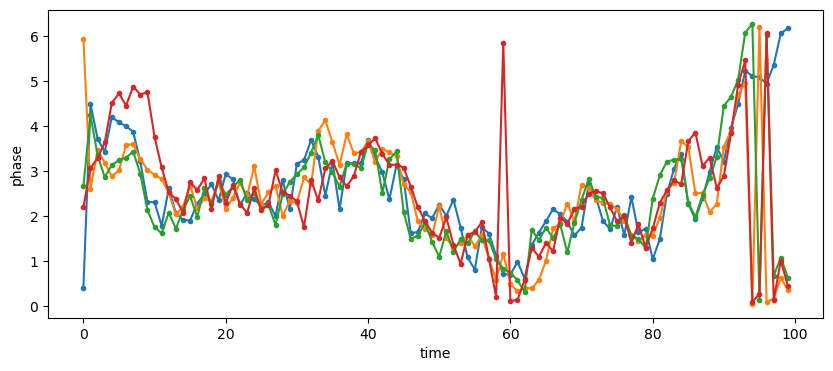

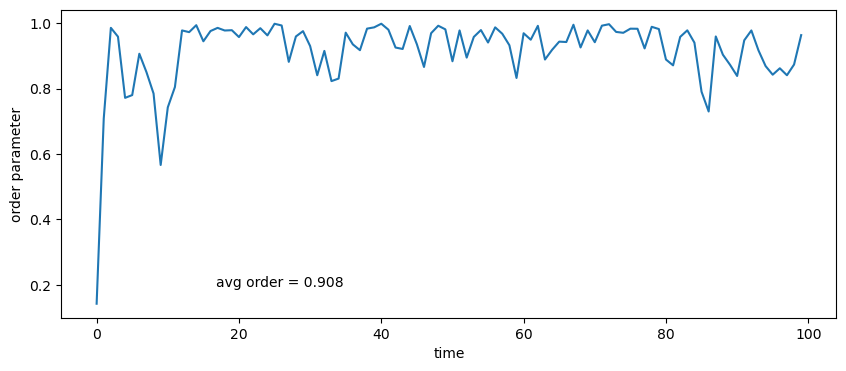

In [67]:
N_to_plot = 4
switching_rate_index_to_plot = 3
mc_iter_to_plot = 2

out_data_to_plot = out_data[N_to_plot, switching_rate_index_to_plot, mc_iter_to_plot]

# plot single trajectories versus time
plt.figure(figsize=(10,4))
plt.plot(out_data_to_plot['t'],(out_data_to_plot['phi']),'.-')
plt.xlabel('time')
plt.ylabel('phase')
#plot order parameter versus time
plt.figure(figsize=(10,4))
ax=plt.subplot()
plt.plot(out_data_to_plot['t'],out_data_to_plot['order'])
plt.xlabel('time')
plt.ylabel('order parameter')
avg_order=np.mean(out_data_to_plot['order'][-25:])
plt.text(0.2,0.1,'avg order = %.3f' % avg_order,transform=ax.transAxes)

Calculate the average order of the monte-carlo simulations

In [68]:
avg_order_over_reps = {}
avg_order = np.empty(shape=(len(switching_rate_arr),n_mc_reps))
for N_i, N in enumerate(N_arr):
    for i_switching_rate in np.arange(len(switching_rate_arr)):
        for mc_iter in np.arange(n_mc_reps):
            out_data_tmp = out_data[N, i_switching_rate, mc_iter]
            avg_order_tmp = np.mean(out_data_tmp['order'][-order_border:])
            avg_order[i_switching_rate, mc_iter] = avg_order_tmp
    # calculate the mean of the average order over monte-carlo reps.
    avg_order_over_reps[N] = np.mean(avg_order, axis=1)


Plot the average vs scanning parameter for all N

Text(0, 0.5, 'average order')

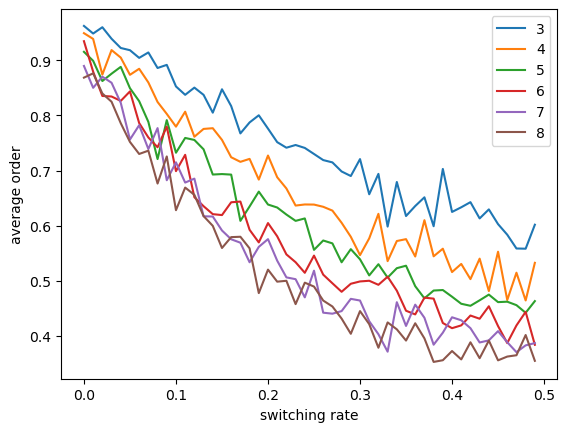

In [69]:
for N in N_arr:
    plt.plot(switching_rate_arr, avg_order_over_reps[N], label=N)
plt.legend()
plt.xlabel("switching rate")
plt.ylabel("average order")